In [1]:
#Import modules

In [3]:
%pylab inline
import tomopy
import dxchange
import matplotlib.pyplot as plt
import h5py
import time
import tifffile
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [4]:
fp = h5py.File('lungProject_data/VILI_mouse_5_pm2_e.h5','r')
ff = h5py.File('lungProject_data/VILI_mouse_5_pm2_refs.h5','r')

In [5]:
proj = fp['exchange/data']
flat = ff['exchange/data_white']
dark = ff['exchange/data_dark']
print(proj.shape, flat.shape, dark.shape)

((901, 1048, 2016), (100, 1048, 2016), (30, 1048, 2016))


If the angular information is not avaialable from the raw data you need to set the data collection angles. In this case theta is set as equally spaced between 0-180 degrees.

In [6]:
theta = tomopy.angles(proj.shape[0])

Perform the flat-field correction of raw data: $$ \frac{proj - dark} {flat - dark} $$

In [7]:
proj = tomopy.normalize(proj, flat, dark)
print(proj.shape)

(901, 1048, 2016)


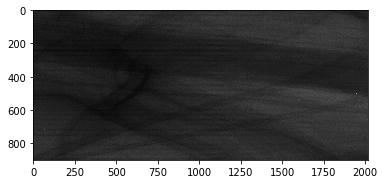

In [8]:
plt.imshow(proj[:,40, :], cmap='Greys_r')
plt.show()

Tomopy provides various methods to [find rotation center](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.rotation.html).

In [9]:
rot_center = tomopy.find_center(proj, theta, init=1008, ind=0, tol=0.5)
print(rot_center)

[1002.4875]


Calculate $$ -log(proj) $$

In [10]:
proj = tomopy.minus_log(proj)

In [ ]:
proj=tomopy.prep.phase.retrieve_phase(proj,pixel_size=0.0003,dist=10,energy=22,alpha=0.00005,pad=True)

Reconstruction using Gridrec algorithm.Tomopy provides various [reconstruction](http://tomopy.readthedocs.io/en/latest/api/tomopy.recon.algorithm.html) methods including the one part of the [ASTRA toolbox](https://sourceforge.net/p/astra-toolbox/wiki/Home/).

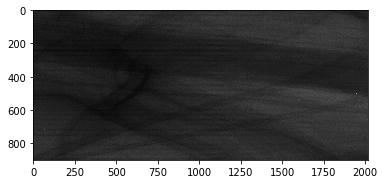

In [14]:
plt.imshow(proj[:, 40,:], cmap='Greys_r')
plt.show()

# Padding to remove the gradient around the FOV in the reconstruction

In [ ]:
N = proj.shape[2]
proj_pad = np.zeros([proj.shape[0],proj.shape[1],3*N//2],dtype = "float32")
proj_pad[:,:,N//4:5*N//4] = proj
proj_pad[:,:,0:N//4] = np.tile(np.reshape(proj[:,:,0],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))
proj_pad[:,:,5*N//4:] = np.tile(np.reshape(proj[:,:,-1],[proj.shape[0],proj.shape[1],1]),(1,1,N//4))

proj = proj_pad
rot_center = rot_center+N//4

# select / define tomo algorithms

In [18]:
def rec_sirtfbp(data, theta, rot_center, start=0, test_sirtfbp_iter = False):

    # Use test_sirtfbp_iter = True to test which number of iterations is suitable for your dataset
    # Filters are saved in .mat files in "./¨
    if test_sirtfbp_iter:
        nCol = data.shape[2]
        output_name = './test_iter/'
        num_iter = [50,100,150]
        filter_dict = sirtfilter.getfilter(nCol, theta, num_iter, filter_dir='./')
        for its in num_iter:
            tomopy_filter = sirtfilter.convert_to_tomopy_filter(filter_dict[its], nCol)
            rec = tomopy.recon(data, theta, center=rot_center, algorithm='gridrec', filter_name='custom2d', filter_par=tomopy_filter)
            output_name_2 = output_name + 'sirt_fbp_%iiter_slice_' % its
            dxchange.write_tiff_stack(data, fname=output_name_2, start=start, dtype='float32')

    # Reconstruct object using sirt-fbp algorithm:
    num_iter = 100
    nCol = data.shape[2]
    sirtfbp_filter = sirtfilter.getfilter(nCol, theta, num_iter, filter_dir='./')
    tomopy_filter = sirtfilter.convert_to_tomopy_filter(sirtfbp_filter, nCol)
    rec = tomopy.recon(data, theta, center=rot_center, algorithm='gridrec', filter_name='custom2d', filter_par=tomopy_filter)
    
    return rec

In [15]:
algorithm = 'gridrec'
#algorithm = 'sirtfbp'

In [16]:
slice_first=500
slice_last=501
aproj=proj[:600,slice_first:slice_last,:]
print(aproj.shape)

(600, 1, 2016)


In [ ]:
if algorithm == 'sirtfbp':
    recon = rec_sirtfbp(aproj, theta, rot_center)
else:
    recon = tomopy.recon(aproj, theta, center=rot_center, algorithm=algorithm, filter_name='parzen')
recon = recon[:,N//4:5*N//4,N//4:5*N//4]
        
print("Algorithm: ", algorithm)

print(recon.shape)

In [23]:
print(recon.shape)

(1, 2016, 2016)


Mask each reconstructed slice with a circle.

In [24]:
recon = tomopy.circ_mask(recon, axis=0, ratio=0.95)

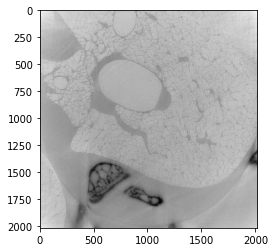

In [25]:
plt.imshow(recon[0, :,:], cmap='Greys_r')
plt.show()

In [27]:
tifffile.imsave('gridrec_alpha1e-4',recon)